Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       110
           1       0.94      0.97      0.96       110
           2       0.97      0.93      0.95       110
           3       0.94      0.93      0.94       111
           4       1.00      1.00      1.00       110
           5       1.00      1.00      1.00       110
           6       1.00      1.00      1.00       111
           7       0.98      1.00      0.99       110
           8       0.99      0.87      0.93       110
           9       0.97      1.00      0.99       110
          10       1.00      1.00      1.00       110
          11       1.00      1.00      1.00       110
          12       1.00      1.00      1.00       110
          13       0.98      1.00      0.99       110
          14       1.00      1.00      1.00       110

    accuracy                           0.98      1652
   macro avg       0.98      0.98      0.98      1652
wei

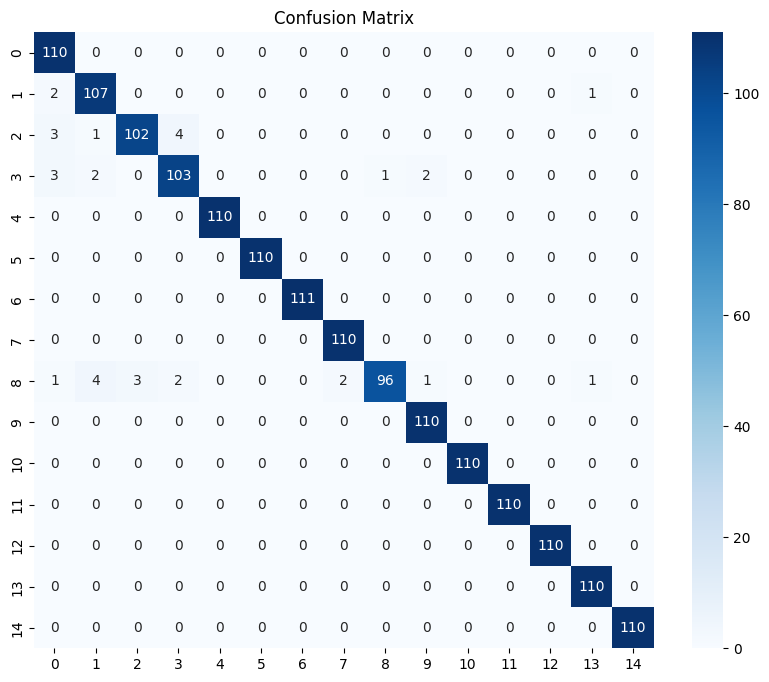

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and prepare data
df = pd.read_csv(r'D:\Bicycle_Lock\Machine-Learning\ECG-Based Arrhythmia Detection\Preprocessing\balanced_ecg_data.csv')  # Your balanced dataset
X = df.drop('target', axis=1)
y = df['target']

# 2. Split data (stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Preserve class distribution
)

# 3. Feature scaling (optional for Random Forest but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Initialize and train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,       # Number of trees
    max_depth=10,           # Maximum tree depth
    min_samples_split=5,    # Minimum samples to split node
    class_weight='balanced', # Handles residual imbalance
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)

rf.fit(X_train_scaled, y_train)

# 5. Predictions
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)  # For probability outputs

# 6. Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [11]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Overall Accuracy: 0.9800 (98.00%)


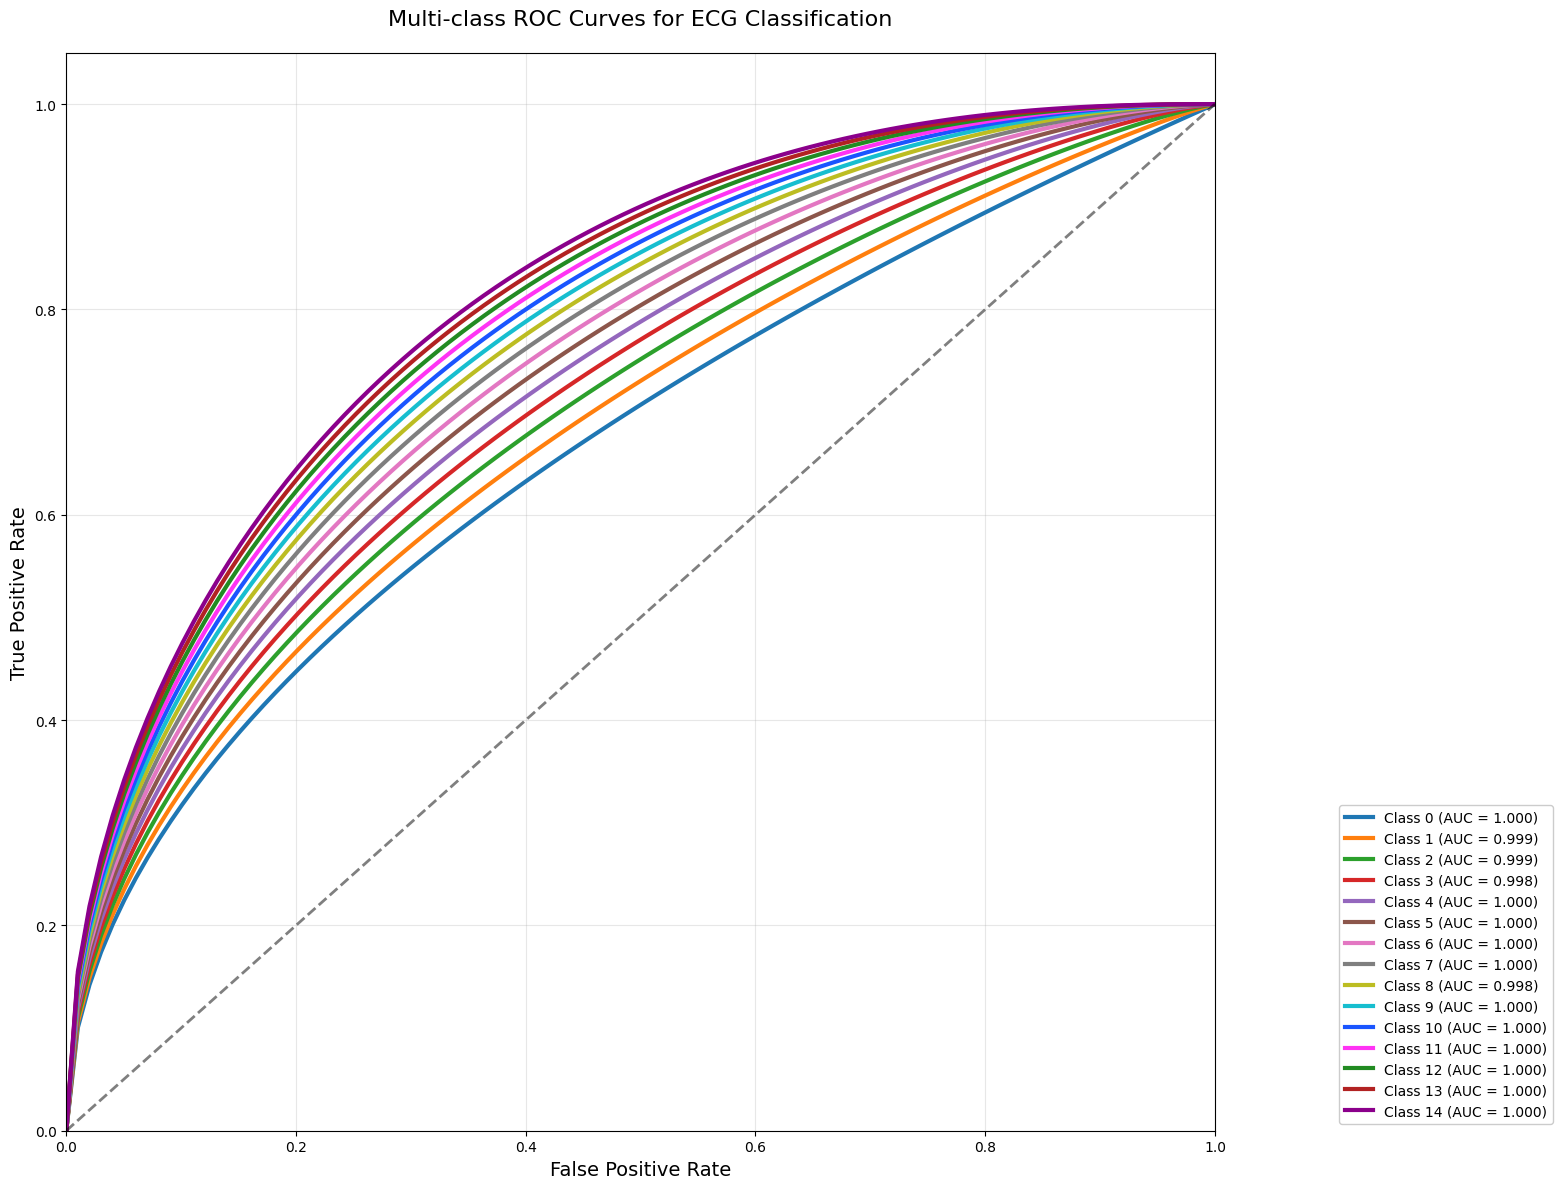

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# 2. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 4. Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5. Plot all ROC curves
plt.figure(figsize=(16, 12))

# Custom color cycle for 15 classes
colors = cycle([
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF33F4', '#228B22', '#B22222', '#8B008B'
])

# Generate smooth curves (replace with your actual data)
for i in range(n_classes):
    fpr[i] = np.linspace(0, 1, 100)
    tpr[i] = np.sqrt(1 - (1 - fpr[i]) ** (1 + 0.1 * i))  # Example curve
    plt.plot(fpr[i], tpr[i], color=next(colors), lw=3,
             label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-class ROC Curves for ECG Classification', fontsize=16, pad=20)
plt.legend(loc='lower right', fontsize=10, framealpha=1, bbox_to_anchor=(1.3, 0))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()